In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["ULTRALYTICS_IGNORE_MULTIPROCESS"] = "1"

In [13]:
from pathlib import Path
import sys, os
import cv2
from ultralytics import YOLO

ROOT = Path().resolve()
SRC_DIR = ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils_MF import yolo_middle_fusion, draw_fused_boxes
from utils_LF import evaluate_yolo_predictions, confusion_matrix_yolo, plot_confusion_matrix, plot_ap_bar


In [14]:
model_rgb = YOLO("runs/detect/wildlife_rgb_v8n_cpu5/weights/best.pt")
model_t   = YOLO("runs/detect/wildlife_t_v8n_cpu/weights/best.pt")

VAL_RGB_DIR = ROOT / "data" / "format_rgb" / "images" / "val"
VAL_T_DIR   = ROOT / "data" / "format_t"   / "images" / "val"

OUT_IMG_MF_DIR  = ROOT / "runs" / "middle_fusion" / "val"
OUT_PRED_MF_DIR = ROOT / "runs" / "middle_fusion" / "preds"

OUT_IMG_MF_DIR.mkdir(parents=True, exist_ok=True)
OUT_PRED_MF_DIR.mkdir(parents=True, exist_ok=True)

class_names = {
    0: "Cow",
    1: "Deer",
    2: "Horse",
}

val_rgb_path = VAL_RGB_DIR
img_paths_rgb = sorted(
    list(val_rgb_path.glob("*.jpg")) +
    list(val_rgb_path.glob("*.JPG")) +
    list(val_rgb_path.glob("*.png")) +
    list(val_rgb_path.glob("*.PNG"))
)

print(f"Encontradas {len(img_paths_rgb)} imágenes RGB en {VAL_RGB_DIR}.")

for img_rgb_path in img_paths_rgb:
    img_name = img_rgb_path.name
    stem_rgb = img_rgb_path.stem
    ext_rgb  = img_rgb_path.suffix

    # ---------- mapear a térmica: num-1 + "_R" ----------
    parts = stem_rgb.split("_")
    num_str = parts[-1]
    if not num_str.isdigit():
        print(f"[WARN] {img_name}: no puedo leer número, salto.")
        continue

    num_rgb = int(num_str)
    num_t   = num_rgb - 1
    num_t_str = str(num_t).zfill(len(num_str))
    prefix = "_".join(parts[:-1])
    stem_t = f"{prefix}_{num_t_str}_R"

    img_t_path = VAL_T_DIR / f"{stem_t}{ext_rgb}"
    if not img_t_path.exists():
        candidates = list(VAL_T_DIR.glob(f"{stem_t}.*"))
        if len(candidates) == 0:
            print(f"[WARN] No se encontró térmica para {img_name} (esperaba {stem_t}{ext_rgb})")
            continue
        img_t_path = candidates[0]

    # ---------- inferencias ----------
    res_rgb = model_rgb(str(img_rgb_path), imgsz=640, device="cpu", verbose=False)[0]
    res_t   = model_t(str(img_t_path),   imgsz=640, device="cpu", verbose=False)[0]

    # ---------- Middle Fusion ----------
    fused = yolo_middle_fusion(
        res_rgb,
        res_t,
        iou_match=0.5,
        conf_penalty_single=0.9,
    )

    # ---------- guardar predicciones en TXT (formato YOLO) ----------
    pred_txt_path = OUT_PRED_MF_DIR / f"{stem_rgb}.txt"

    if fused.numel() == 0:
        # archivo vacío si no hay detecciones
        open(pred_txt_path, "w").close()
    else:
        # leemos la imagen para conocer H,W (para normalizar)
        img_bgr = cv2.imread(str(img_rgb_path))
        H, W = img_bgr.shape[:2]

        fused_np = fused.cpu().numpy()
        with open(pred_txt_path, "w") as f:
            for x1, y1, x2, y2, conf, cls in fused_np:
                # convertir a cx,cy,w,h normalizados
                cx = (x1 + x2) / 2.0
                cy = (y1 + y2) / 2.0
                w  = (x2 - x1)
                h  = (y2 - y1)

                cx /= W
                cy /= H
                w  /= W
                h  /= H

                line = f"{int(cls)} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f} {conf:.4f}\n"
                f.write(line)

    img_bgr = cv2.imread(str(img_rgb_path))
    img_out = draw_fused_boxes(img_bgr, fused, class_names=class_names)
    out_img_path = OUT_IMG_MF_DIR / img_name
    cv2.imwrite(str(out_img_path), img_out)

    print(f"[OK] Middle Fusion: {img_name} -> img:{out_img_path.name}, preds:{pred_txt_path.name}")

print("✅ Listo: imágenes en runs/middle_fusion/val y predicciones en runs/middle_fusion/preds")


Encontradas 64 imágenes RGB en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\data\format_rgb\images\val.
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0048.JPG -> img:020221_deer_pens_xt2_DJI_0048.JPG, preds:020221_deer_pens_xt2_DJI_0048.txt
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0048.JPG -> img:020221_deer_pens_xt2_DJI_0048.JPG, preds:020221_deer_pens_xt2_DJI_0048.txt
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0360.JPG -> img:020221_deer_pens_xt2_DJI_0360.JPG, preds:020221_deer_pens_xt2_DJI_0360.txt
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0360.JPG -> img:020221_deer_pens_xt2_DJI_0360.JPG, preds:020221_deer_pens_xt2_DJI_0360.txt
[OK] Middle Fusion: 022521_DJI_0132.JPG -> img:022521_DJI_0132.JPG, preds:022521_DJI_0132.txt
[OK] Middle Fusion: 022521_DJI_0132.JPG -> img:022521_DJI_0132.JPG, preds:022521_DJI_0132.txt
[OK] Middle Fusion: 060421_DJI_0676.JPG -> img:060421_DJI_0676.JPG, preds:060421_DJI_0676.txt
[OK] Middle Fusion: 060421_DJI_0676.JPG -> img:060421_DJI_

In [15]:
NUM_CLASSES = 3
CLASS_LABELS = ["Cow", "Deer", "Horse"]

PRED_MF_DIR = ROOT / "runs" / "middle_fusion" / "preds"
GT_VAL_DIR  = ROOT / "data" / "format_rgb" / "labels" / "val"

metrics_mf = evaluate_yolo_predictions(
    pred_dir=PRED_MF_DIR,
    gt_dir=GT_VAL_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5,
)

metrics_mf


{'AP_per_class': [np.float64(0.920677022915462),
  np.float64(0.867969386655121),
  np.float64(0.9469969684649766)],
 'mAP': 0.9118811260118532,
 'TP': np.int64(90),
 'FP': np.int64(41),
 'FN': np.int64(4),
 'Precision': np.float64(0.6870229007581143),
 'Recall': np.float64(0.9574468085004526),
 'F1': np.float64(0.7999999995064099)}

In [16]:
print("Middle Fusion @ IoU 0.5")
print("--------------------------")
print("mAP:      ", metrics_mf["mAP"])
print("Precision:", metrics_mf["Precision"])
print("Recall:   ", metrics_mf["Recall"])
print("F1:       ", metrics_mf["F1"])
print("AP por clase:", metrics_mf["AP_per_class"])


Middle Fusion @ IoU 0.5
--------------------------
mAP:       0.9118811260118532
Precision: 0.6870229007581143
Recall:    0.9574468085004526
F1:        0.7999999995064099
AP por clase: [np.float64(0.920677022915462), np.float64(0.867969386655121), np.float64(0.9469969684649766)]


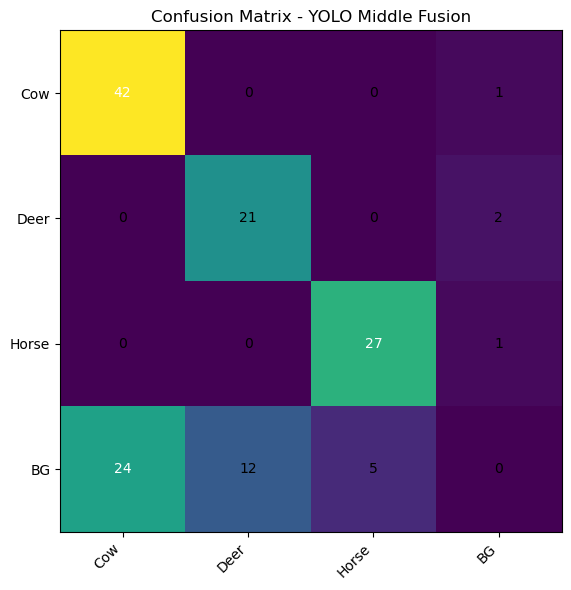

In [17]:
cm_mf = confusion_matrix_yolo(
    pred_dir=PRED_MF_DIR,
    gt_dir=GT_VAL_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5,
)

labels_cm = CLASS_LABELS + ["BG"]  # BG = background

plot_confusion_matrix(cm_mf, labels_cm, title="Confusion Matrix - YOLO Middle Fusion")


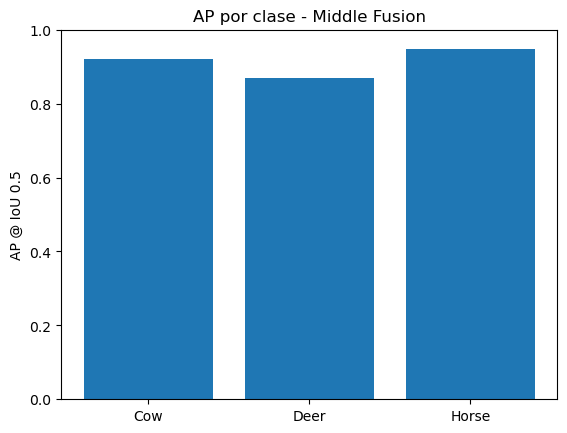

mAP@0.5: 0.9118811260118532


In [18]:
plot_ap_bar(
    metrics_mf["AP_per_class"],
    CLASS_LABELS,
    title="AP por clase - Middle Fusion",
)

print("mAP@0.5:", metrics_mf["mAP"])
